# Project Objectives:
1. Use standard Bloomberg OIS and IRS data to bootstrap swap curves
2. Calibrate swaption using SABR
3. CMS convexity correction
5. Extend the functions above to any standardised Bloomberg data
6. Use relavant codes to export data back to excel

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
#Load OIS data with daycount act/360
# The data in use are all standardised from BGN Terminal
# BGN shows 10-year OIS. For data beyond 10 years we use IRS quotes 
d_ois = pd.read_excel('data 3.11.xlsx',sheet_name = 'OIS')[0:18]
d_irs = pd.read_excel('data 3.11.xlsx',sheet_name = 'IRS')[0:23] 
frame = [d_ois,d_irs[15:]]
d_ois = pd.concat(frame)

In [3]:
# Define datetime object today according to data for later use
today = datetime.datetime.strptime(d_ois['Update'].iloc[-1],'%m/%d/%y')
last_day = datetime.datetime(today.year,12,31)
today

datetime.datetime(2019, 3, 11, 0, 0)

In [4]:
# Datetime functions
# Get the next business day
def payment_date(date, # The maturity date of the contract, a datetime object
                ):
    today = date.isoweekday()
    # The contract matures on a business day and no change is needed
    if today<=5:
        return date
    # The contract matures on a non-working day (doesn't consider public holiday)
    else: 
        p_d = date+datetime.timedelta(days=7-today+1)
        return p_d

#Get tenor in days for OIS with act/360 daycount, this function returns int
#This function can be applied to both OIS and IRS
#This function is coded to solve standised Bloomberg quote (1d, 1w, 2w, 1m...)
def get_tenor(string):
    ret = 0
    if 'D' in string: #1D
        maturity = today + datetime.timedelta(days=1)
        ret = 1
        
    elif 'W' in string: #1W, 2W, 3W
        number = int(string.replace('W',''))*7
        maturity = today + datetime.timedelta(days=number)
        ret = number

    elif 'M' in string: #1M, 2M, 3M, 4M, 5M, 6M, 9M, 18M
        number = int(string.replace('M',''))
        mtye = last_day.month-today.month # Months till year end
        if mtye < number: # The contract doesn't end in same year
            if mtye+12 < number: # The contract spans across 3 years
                maturity = datetime.datetime(today.year+2,number-(mtye+12),today.day)
            else: # The contract ends next year
                maturity = datetime.datetime(today.year+1,number-mtye,today.day)
        else: # The contract ends in the same year
            maturity = datetime.datetime(today.year,today.month+number,today.day)
        ret = (maturity - today).days
        
    else: # 1, 2, 3, 4, 5, 10Y
        y_d = int(string.replace('Y',''))
        maturity = datetime.datetime(today.year+y_d,today.month,today.day)
        ret = (maturity - today).days
    return ret
d_ois['Tenor Days'] = d_ois['Tenor'].apply(get_tenor)
d_ois['Tenor Years'] = d_ois['Tenor Days']/360 # act/360
d_ois['Maturity Date'] = d_ois['Tenor Days'].apply(datetime.timedelta)+today
d_ois['Payment Date'] = d_ois['Maturity Date'].apply(payment_date)
d_ois.iloc[::2,[0,1,3,4,6,8]]

,Tenor,CUSIP,Yield,Source,Tenor Days,Maturity Date
0,1D,FEDL01 Index,2.40000,,1,2019-03-12
2,2W,USSO2Z CMPN Curncy,2.40055,CMPN,14,2019-03-25
4,1M,USSOA CMPN Curncy,2.40000,CMPN,31,2019-04-11
6,3M,USSOC CMPN Curncy,2.40735,CMPN,92,2019-06-11
8,5M,USSOE CMPN Curncy,2.40565,CMPN,153,2019-08-11
10,9M,USSOI CMPN Curncy,2.41065,CMPN,275,2019-12-11
12,18M,USSO1F CMPN Curncy,2.37105,CMPN,550,2020-09-11
14,3Y,USSO3 CMPN Curncy,2.27400,CMPN,1096,2022-03-11
16,5Y,USSO5 CMPN Curncy,2.24600,CMPN,1827,2024-03-11
15,11Y,USSWAP11 BGN Curncy,2.69078,BGN,4018,2030-03-11


## Matching the Quotes:


By PV Floating = PV Fixed :
$$
\Pi_{i=1}^{N}(1+\Delta_{i-1}·\frac{1}{\Delta_{i-1}}·\frac{D_o(0,t_{i-1})-D_o(0,t_i)}{D_o(0,t_i)})-1 = OIS_t \Delta_t \sum_{i=1}^{t}D_0(t_i)$$

$$
\Pi_{i=1}^{N}\frac{D_o(0,t_{i-1})}{D_o(0,t_i)}-1 = OIS_t \Delta_t \sum_{i=1}^{t}D_0(t_i)
$$
Hence we get for single payment contracts (ends within one year):
$$
\frac{1}{D_o(0,t_N)}-1 = OIS_t \Delta_t \sum_{i=1}^{t}D_0(t_i)
$$
For multiple payment contracts:

$$
D(0,T_i)\Pi_{i=1}^{365}(1+\delta f) = D(0,T_{i-1})
$$

$$
D(0,T_i)\Pi_{i=1}^{365}(1+\delta f)-D(0,T_i)= D(0,T_{i-1}) - D(0,T_i)
$$

In [5]:
# All global data are initially defined using this cell
# 1. Actual days in year, 2. PVBP 
# 3. bisection search of dfs that matches all observable contract tenors 
# 4. dfs of each year
# BGN shows OIS quotes for ten years and from 11th years onwards IRS is used

# Here we use a separate list to store all the dfs for OIS quotes table
odfs_t = np.zeros(17)

#This is the list of 3m time interval odfs 
len_dfs = int(d_irs['Tenor'].iloc[-1].replace('Y',''))*4 #len = 200
odfs = np.zeros(len_dfs)

#odfs_y is a list of yearly discount factors
odfs_y = np.append(odfs[3::4],[0])

# 1.How many actual days in one year
def d_in_y(T# Tenor
          ):
    doy = np.zeros(T+1) # days of years, the days of first year is at index 1
    for i in range(1,T+1):
        maturity = datetime.datetime(today.year+i,today.month,today.day)
        doy[i] = int((maturity-today).days)-sum(doy[:i])
    return doy
doy = d_in_y(len_dfs+1)

#2. Calculate the PVBP for an multi-paynement OIS contract
def PVBP(T, # Contract tenor
         guess, # initial guess
         daycount ='ACT/360'):
    ret = np.zeros(T+1) # of length T+1
    diy = doy[:T+1] # of length T+1
    copy = odfs_y.copy()
    # Renew the dfs with intepolation
    fu = 1 #first unknown df in odfs_y
    while(odfs_y[fu]!=0):
        fu+=1
    if fu==T: # No interpolation needed
        ret = np.append(copy[:T],guess) #retrun is all the known dfs and the guess
    else:
        # Known dfs,
        k_d = copy[:fu-1]
        # Unknown part of PVBP, solved with interpolation
        u_d = pd.Series(np.linspace(copy[fu-1],guess,T-fu+1+1))
        ret = np.append(k_d,u_d)
    if daycount == 'ACT/360':
        ret = ret*pd.Series(diy/360) #ret is of length T+1
    else:
        ret = pd.Series(odfs_y[:T+1])
    return ret

# For Tenor less than 1 year, only one payment is needed
# For 18M contract, the first payment is in 6-month and the second is on maturity

#3. This function uses bisection to find the OIS for every contract except 18M one
def bi_oisdf(s, #swap rate
           T, #Tenor of contract. T is a string obatined from the Tenor column
           m='s'#s is for single payment, m is for multiple payment
            ):
    # single payment, solve for OIS*dt*D^2 = 1 - D
    tol = 10**(-10)
    ret = None
    # ACT/360 single payment
    if m=='s':
        ll, ul, diff = 0.8, 1, 0 # lower limit, upper limit 
        dt = get_tenor(T)/360
        while(True):
            guess = (ll+ul)/2
            diff = s*dt*guess**2+guess-1
            if abs(diff)<tol: # solution found
                ret = guess
                break
            else:
                if diff>0:
                    ul = guess
                else:
                    ll = guess
    # multiple payments 
    else:
        ll, ul, diff = 0.1, 1, 0 # lower limit, upper limit 
        ten = int(T.replace('Y',''))
        while(True):
            guess = (ll+ul)/2
            diff = s*sum(PVBP(ten,guess))+guess-1
            if abs(diff)<tol: # solution found
                ret = guess
                break
            else:
                if diff>0:
                    ul = guess
                else:
                    ll = guess
    return ret

#4. Get the Discount Factors from the multi-payment OIS quotes by applying bi_oisdf
def OISDF(s, # swap rate
          T, # tenor, this a string input, quoted directly from the data sheet
          odfs_y):
    ret = None
    tenor_d = get_tenor(T) #tenor in days
    # A special case where one payment is 6 month, the other is on maturity
    if T=='18M': 
        maturity = today + datetime.timedelta(days=tenor_d)
        s_pd = maturity # Second, first payment date
        f_pd = datetime.datetime(s_pd.year-1,s_pd.month,s_pd.day) 
        dtf, dts = (f_pd-today).days/360, (s_pd-today).days/360
        ret = (1-s*odf_s[9]*dtf)/(1+s*dts)
    # Annual payments for multiple years
    else:
        i_s = int(T.replace('Y',''))#renew the discount factor list
        ret = bi_oisdf(s,T,m='m')  
    return ret

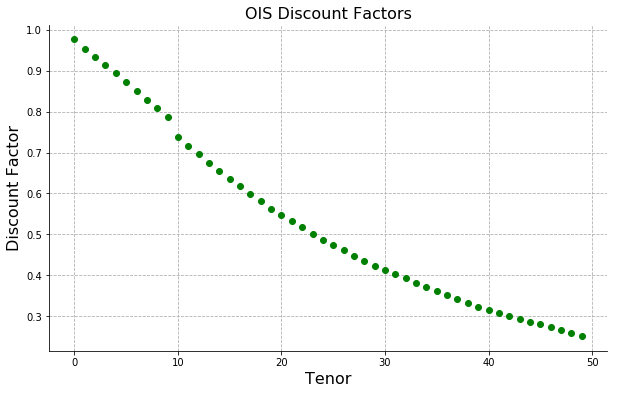

In [6]:
# Get the odfs for all single payment contract, including 1Y contract
odf_s = np.zeros(12) # There are 12 single payment contracts from a single quote
for i in range(len(odf_s)):
    odf_s[i] = bi_oisdf(d_ois['Yield'].iloc[i]/100,d_ois['Tenor'].iloc[i])
odfs_y[1] = odf_s[-1]

# Get OIS for 18 month contract
d_18 = OISDF(d_ois['Yield'].iloc[12]/100,d_ois['Tenor'].iloc[12],odfs_y)

# OIS for multiple payment contract
for i in range(13,26):
    iy = int(d_ois['Tenor'].iloc[i].replace('Y',''))
    odfs_y[iy] = OISDF(d_ois['Yield'].iloc[i]/100,d_ois['Tenor'].iloc[i],odfs_y)
    #intepolation
    # find the index of the first unknown
    if i!=13:
        fu = int(d_ois['Tenor'].iloc[i-1].replace('Y',''))+1
    else:
        fu = 1+1
    inte = np.linspace(odfs_y[fu-1],odfs_y[iy],iy-fu+1+1)
    for i1 in range(fu-1,iy+1):
        odfs_y[i1] = inte[i1-fu+1]

#plotting
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(odfs_y[1:], 'go')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(linestyle = '--', alpha = 1)
ax.set_title('OIS Discount Factors',fontsize=16)
ax.set_xlabel('Tenor',fontsize=16)
ax.set_ylabel('Discount Factor',fontsize=16)
plt.show()

In [7]:
# load data
d_irs = pd.read_excel('data 3.11.xlsx',sheet_name = 'IRS')[0:23] 

In [8]:
def get_tenor_irs(string):
    ret = None
    if 'M' in string:
        ret = int(string.replace('M',''))/12
    else:
        ret = int(string.replace('Y',''))
    return ret

#Get time delta in years for 30/360 and act/360, this function returns floats
d_irs['Tenor Days'] = d_irs['Tenor'].apply(get_tenor)
d_irs['Tenor Years'] = d_irs['Tenor Days']/360 # act/360
d_irs['Maturity Date'] = d_irs['Tenor Days'].apply(datetime.timedelta)+today
d_irs['Payment Date'] = d_irs['Maturity Date'].apply(payment_date)
d_irs['Fixed Leg Dt'] = d_irs['Tenor'].apply(get_tenor_irs)
d_irs.iloc[::2,[0,1,3,4,6,8]]

,Tenor,CUSIP,Yield,Source,Tenor Days,Maturity Date
0,3M,US0003M CMPN Index,2.59663,CMPN,92,2019-06-11
2,9M,EDU9 BGN Comdty,2.60868,BGN,275,2019-12-11
4,15M,EDH0 BGN Comdty,2.55618,BGN,458,2020-06-11
6,2Y,USSWAP2 BGN Curncy,2.60220,BGN,731,2021-03-11
8,4Y,USSWAP4 BGN Curncy,2.51730,BGN,1461,2023-03-11
10,6Y,USSW6 BGN Curncy,2.53900,BGN,2192,2025-03-11
12,8Y,USSW8 BGN Curncy,2.59600,BGN,2922,2027-03-11
14,10Y,USSWAP10 BGN Curncy,2.66090,BGN,3653,2029-03-11
16,12Y,USSWAP12 BGN Curncy,2.71830,BGN,4383,2031-03-11
18,20Y,USSWAP20 BGN Curncy,2.81790,BGN,7305,2039-03-11


Although the two legs use differnent daycount convention, their payments happen in the same day and both legs use OIS discounting

The Floating leg is of quarterly Libor payment with daycount Act/360:
$$
    D(0,T_i) \Delta_{3m,act/360}L(T_{i-1},T_i)= \sum_{i=1}^{n}D(0,T_{i-1})-D(0,T_{i})
$$
where:
$$
\sum_{i=1}^{n}D(0,T_{i-1})-D(0,T_{i}) = 1- D(0,T_i)
$$

The Fixed leg is of Semi-Annual payment with daycount 30/360, following Treasury Bill:
$$
IRS_t \Delta_{3m,30/360} \sum_{i=1}^{n}D(0,T_i)
$$

By PV Fixed = PV Floating:
$$
IRS_t \Delta_{3m,30/360} \sum_{i=1}^{n}D(0,T_i) = 1- D(0,T_i)
$$
Here $\Delta_t\sum_{i=1}^{t}D(0,t_i)$ is the denominator of the par IRS swap rate, and can be interpreted as PVBP (Present Value of a Basis Point): $$P_{1,n} = \sum_{i=1}^{t}D(0,T_i)$$

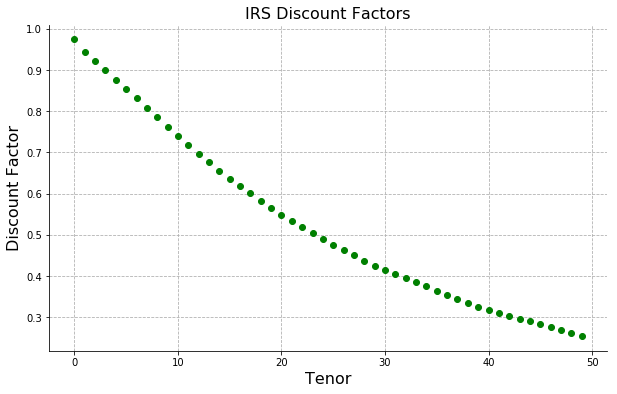

In [9]:
# 1. odfs is the list of 3m OIS discount factors, length 200
odfs = np.zeros(len_dfs)

# 2. days in every 3 month period
di3m = np.zeros(len_dfs)

# Get the actual days for every 3 month period
# This will be used when calculating implied forward Libor
last_pd = today
next_pd = today
for i in range(len_dfs):
    if last_pd.month <= 9: # The contract ends in the same year
        next_pd = datetime.datetime(last_pd.year,last_pd.month+3,last_pd.day)
    else: # The contract ends next year
        next_pd = datetime.datetime(last_pd.year+1,last_pd.month+3-12,last_pd.day)
    di3m[i] =  (next_pd-last_pd).days
    last_pd = next_pd
    
# For 3M to 18M contract, no interpolation is needed
for i in range(6):
    if i==0:
        k_d = 0 # known dfs
    else:
        k_d = sum(odfs[:i])
    irs = d_irs['Yield'].iloc[i]/100
    dt = 90/360
    odfs[i] = (1-irs*dt*k_d)/(1+irs*dt)

# From 18M onwards, only yearly contracts are quoted and interpolation is needed

#There are 23 observable contracts on the market
len_irs = d_irs.index.values[-1]+1
for i in range(6,len_irs):#len_irs):
    s = d_irs['Yield'].iloc[i]/100
    dt = 90/360
    # find the first unknown df
    fu = 6
    while(odfs[fu]!=0):
        fu+=1
    k_d = odfs[:fu] #sum of known dfs, of length fu-1
    
    # Last unknown, the index of the last df of the contract
    lu = get_tenor_irs(d_irs['Tenor'].iloc[i])*4-1
    # Use bisection to get the df
    tol = 10**(-10)
    ll, ul, diff = 0.1, 1, 0 # lower limit, upper limit
    while(True):
        guess = (ll+ul)/2
        u_d = np.linspace(odfs[fu-1],guess,lu-fu+1+1)
        diff = s*dt*(sum(k_d)+sum(u_d))+guess-1
        if abs(diff)<tol:
            for i1 in range(fu,lu+1):
                odfs[i1] = u_d[i1-fu+1]
            break
        else:
            if diff>0:
                ul = guess
            else:
                ll = guess

#plotting
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(odfs[3::4], 'go')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(linestyle = '--', alpha = 1)
ax.set_title('IRS Discount Factors',fontsize=16)
ax.set_xlabel('Tenor',fontsize=16)
ax.set_ylabel('Discount Factor',fontsize=16)
plt.show()

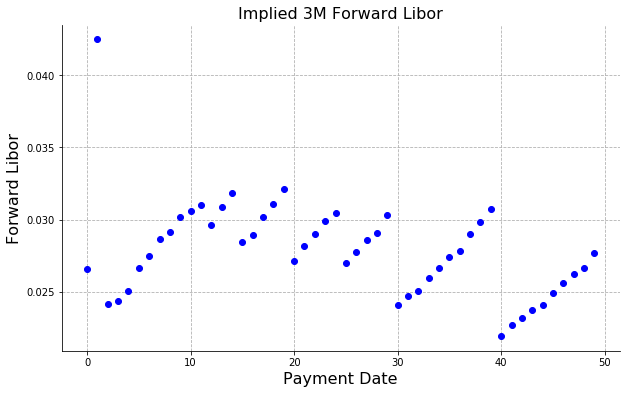

In [10]:
# Get 3-month Implied Libor
imp_lib = np.zeros(len_dfs)
for i in range(len_dfs):
    if i!=0:
        imp_lib[i] = (odfs[i-1]-odfs[i])/odfs[i]/(di3m[i]/360)
    else:
        imp_lib[0] = (1-odfs[0])/odfs[0]/(di3m[0]/360)
        
#plotting
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(imp_lib[3::4], 'bo', lw=20)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(linestyle = '--', alpha = 1)
ax.set_title('Implied 3M Forward Libor',fontsize=16)
ax.set_xlabel('Payment Date',fontsize=16)
ax.set_ylabel('Forward Libor',fontsize=16)
plt.show()

## Calculate Forward Swap Rates:

The Floating Leg is of quarterly payment by ACT/360 daycount:
$$
\sum_{i=e}^{e+t}\Delta_{3m,ACT/360}L(T_{i},T_{i+1})D(0,T_{i+1})
$$
The Fixed Leg is of semi-annual payment by 30/360 daycount, or PVBP:
$$
\sum_{i=e}^{e+t}\Delta_{6m,30/360}D(0,T_{i+1})
$$
Hence, the Forward Swap Rate can be calculated by Floating Leg divided by the Fixed Leg:
$$
IRS_{Forward} = \frac{\sum_{i=e}^{e+t}\Delta_{3m,ACT/360}L(T_{i},T_{i+1})D(0,T_{i+1})}{\sum_{i=e}^{e+t}\Delta_{6m,30/360}D(0,T_{i+1})}
$$

In [11]:
# BGN shows quotes for upto 50 years 
#we can only calibrate for contracts as far as 30x20
d_ir = pd.read_excel('data 3.11.xlsx',sheet_name='IR Swaption')[:-1]

# Get Expiry and Tenor separate
ir_q = d_ir['Expiry x Tenor']
exp, ten = [], []
len_ir = d_ir.index.values[-1]+1
for i in range(len_ir):
    spl = ir_q[i].split('x')
    if 'Mo' in spl[0]:
        exp.append(int(spl[0].replace('Mo',''))/12)
    else:
        exp.append(int(spl[0].replace('Yr','')))
    ten.append(int(spl[1].replace('Yr','')))
    
# Calculate the forwards
def fir(expiry,
        tenor):
    start_con = int(expiry*4) # contract of start
    len_con = int((expiry+tenor)*4) # length of contract
    sum_flt, sum_fix = 0, 0
    # Floating Leg
    for i in range(start_con,len_con):
        dt_flt = di3m[i]/360
        sum_flt += dt_flt*imp_lib[i]*odfs[i]
    # Fixed Leg
    dt_fix = 0.5 
    odf = odfs[start_con+1:len_con:2].copy()
    for i in range(len(odf)):
        sum_fix += dt_fix*odf[i]
    return sum_flt/sum_fix
firs = []
for i in range(len_ir):
    firs.append(fir(exp[i],ten[i]))

#Plotting
firs_df = firs.copy()
firs_df.append(math.nan)
firs_df = np.array(firs_df).reshape(5,7)
x_lab = ['3Mo x','1Yr x','2Yr x','5Yr x','10Yr x','20Yr x','30Yr x']
y_lab = ['2Yr','5Yr','10Yr','20Yr','30Yr']
pd.DataFrame(firs_df,index=y_lab,columns=x_lab)

,3Mo x,1Yr x,2Yr x,5Yr x,10Yr x,20Yr x,30Yr x
2Yr,0.029100,0.026499,0.027394,0.028608,0.028589,0.028264,0.026511
5Yr,0.027679,0.028678,0.028596,0.024092,0.025381,0.027399,0.028404
10Yr,0.028317,0.026878,0.028223,0.029326,0.029360,0.028750,0.030573
20Yr,0.030604,0.030294,0.029565,0.028893,0.027605,0.028797,0.028590
30Yr,0.027829,0.026990,0.024230,0.025143,0.026830,0.025806,NaN


# Part II: Swaption Calibration with SABR

In [12]:
bps_range = d_ir.columns
d_ir.columns =['Expiry x Tenor']+[-0.02, -0.01, -0.005, -0.0025] + ['ATM'] + [0.0025, 0.005, 0.01, 0.02]
d_ir['Contract Expiry'] = exp
d_ir['Contract Tenor'] = ten

In [13]:
from sabr import SABR
import scipy.optimize as optimize
# This function calibrate SABR to the market quotes 
def SABR_calibration(expiry, # contract expiry exp
                     tenor, # contract tenor ten
                    ): 
    # Get the index of the contract
    con_ind = 0
    for i1 in range(len_ir):
        if (exp[i1] == float(expiry)) & (ten[i1] == float(tenor)):
            con_ind = i1
            break
            
    # Get vols for the contract
    con_vol = d_ir.iloc[con_ind][1:10]
    atm_vol = con_vol[4]
    
    # Get vol from SABR for every bps change on the contract
    bps_change = d_ir.columns.values[1:10]
    bps_change[4] = 0
    F = firs[con_ind]# Forward Swap Rate
    def get_vol_lst(guess):
        vol_lst = []
        for bps,vol in zip(bps_change,con_vol):
            vol_lst.append(SABR(F,F+bps,tenor,
                           guess[0],guess[1],guess[2],guess[3]))
        return vol_lst
    
    # Use error norm to calibrate
    sabr_calib = lambda x: np.linalg.norm(con_vol - get_vol_lst(x))
    guess = [0.5,0.5,0.5,0.5] # alpha>=0, 0<=beta<=1, -1<rho<1, nu
    res = optimize.least_squares(lambda x: sabr_calib(x),guess)
    return res['x'], get_vol_lst(res['x'])

# List of parameters and calibrated ATM vol
para_lst = []
ccon_vol = []

for i in range(len_ir):
    res = SABR_calibration(exp[i],ten[i])
    para_lst.append(res[0])
    ccon_vol.append(res[1])

In [14]:
# Show the calibrated parameters of SABR for different contracts
c_para = pd.DataFrame(para_lst,
                      columns=['Alpha','Beta','Rho','Nu'],
                      index=d_ir['Expiry x Tenor'].values)
c_para[::3]

,Alpha,Beta,Rho,Nu
3Mo x 2Yr,0.449442,0.237238,0.489341,0.486097
3Mo x 20Yr,0.397784,0.388411,0.468517,0.449832
1Yr x 5Yr,0.602310,0.382661,0.515526,0.522721
1Yr x 30Yr,0.428311,0.450554,0.475026,0.458753
2Yr x 10Yr,0.617539,0.448414,0.529537,0.545053
5Yr x 2Yr,0.777817,0.374813,0.543767,0.560076
5Yr x 20Yr,0.553072,0.482470,0.515941,0.526942
10Yr x 5Yr,0.681904,0.408298,0.537392,0.555268
10Yr x 30Yr,0.474621,0.482914,0.490532,0.484646
20Yr x 10Yr,0.582513,0.448279,0.519374,0.530319


In [15]:
# Show calibrated contract vols
ccon_vol_lst = pd.DataFrame(ccon_vol,
                            columns=bps_range[1:],
                            index=d_ir['Expiry x Tenor'].values)
ccon_vol_lst.loc[::3,['-200bps','-100bps','ATM','100bps','200bps']]

,-200bps,-100bps,ATM,100bps,200bps
3Mo x 2Yr,65.151625,32.743620,22.508113,17.459975,14.438259
3Mo x 20Yr,54.154042,30.736590,22.616824,18.357190,15.690092
1Yr x 5Yr,68.437536,34.448165,24.610543,19.734970,16.766424
1Yr x 30Yr,44.463295,27.458599,21.172906,17.747048,15.542284
2Yr x 10Yr,52.066836,30.460289,23.149552,19.278144,16.821853
5Yr x 2Yr,64.602329,33.663829,24.383734,19.727188,16.870905
5Yr x 20Yr,39.903921,26.522781,21.156716,18.119805,16.117972
10Yr x 5Yr,43.314343,27.696132,21.415838,17.909137,15.630248
10Yr x 30Yr,39.283048,25.684178,20.382700,17.413983,15.468456
20Yr x 10Yr,39.345506,24.510026,19.012263,16.007864,14.069569


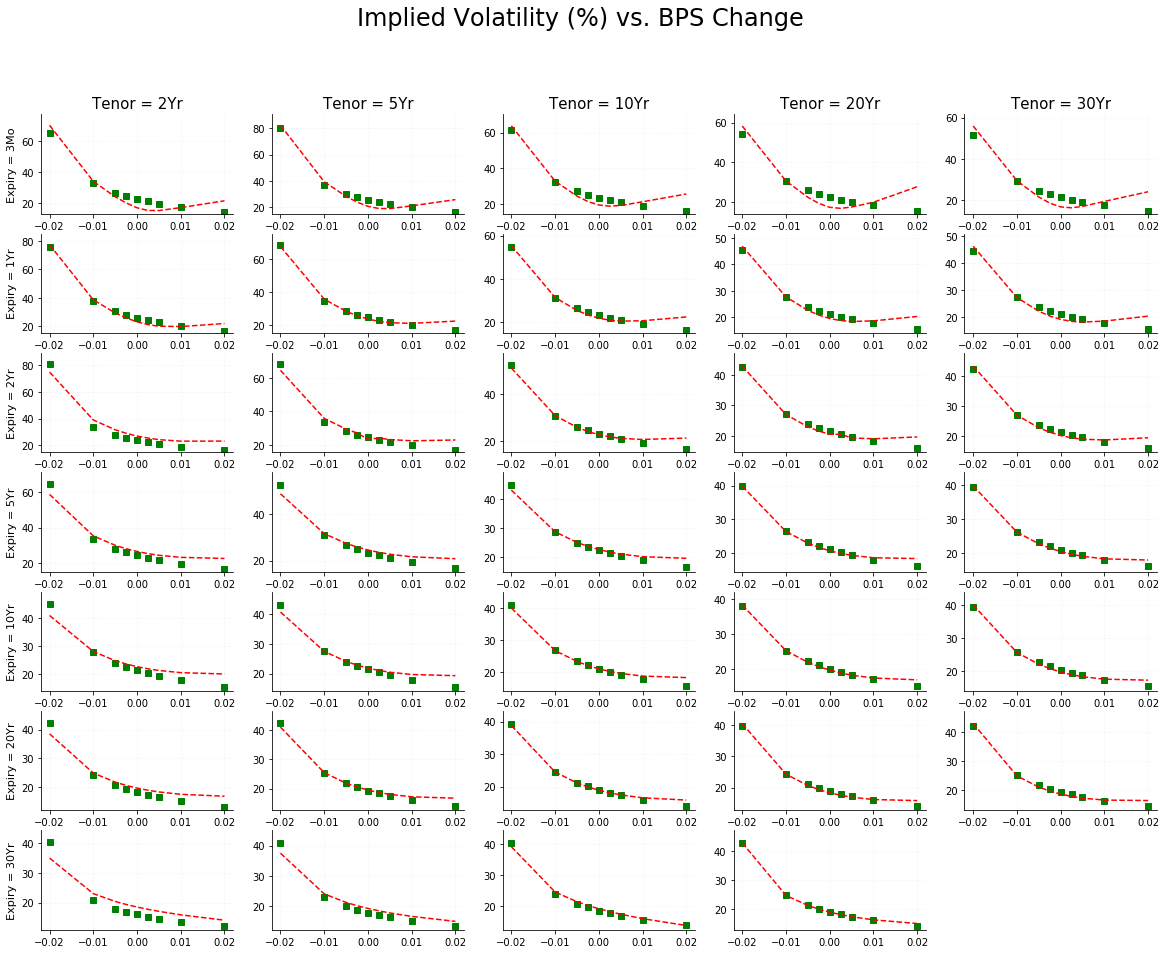

In [16]:
#plotting
width = 2
length = 1.5
expiry_lst = [0.25, 1, 2, 5, 10, 20, 30] 
tenor_lst = [2, 5, 10, 20, 30] 
bps_chg = d_ir.columns.values[1:10]
bps_chg[4] = 0

# Get the upper and lower bound of the axis for plots
# max, min row axis label of contract vol
max_con_vol, min_con_vol = [], []
for i in range(len_ir):
    max_con_vol.append(max(ccon_vol_lst.iloc[i]))
    min_con_vol.append(min(ccon_vol_lst.iloc[i]))
# max, min row axis label of vol
max_q_vol, min_q_vol = [], []
for i in range(len_ir):
    max_q_vol.append(max(d_ir.iloc[i][1:10]))
    min_q_vol.append(min(d_ir.iloc[i][1:10]))

axis_max, axis_min = [], [] 
for i in range(len_ir):
    axis_max.append(max(max_con_vol[i],max_q_vol[i])*1.1)
    axis_min.append(min(min_con_vol[i],min_q_vol[i])*0.9)

#Start plotting
fig = plt.figure(figsize = (width*10,length*10))
fig.suptitle('Implied Volatility (%) vs. BPS Change',fontsize=24)

for i1 in range(len(expiry_lst)):
    for i2 in range(len(tenor_lst)):
        if (i1==len(expiry_lst)-1) & (i2==len(tenor_lst)-1):
            break
        else:
            ind = i1*5+i2
            ax = fig.add_subplot(len(expiry_lst),len(tenor_lst),ind+1) #plot index, plot column
            ax.plot(bps_chg, ccon_vol[ind], 'gs')
            ax.plot(bps_chg, d_ir.iloc[ind].values[1:10], 'r--')
            ax.spines['top'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.grid(linestyle='--',alpha = 0.1)
            ax.set_ylim(axis_min[ind],axis_max[ind])
            if i2 == 0:
                if i1 == 0:
                    ax.set_ylabel('Expiry = %sMo'%(int(expiry_lst[i1]*12)), fontsize = length * 7.5)
                else:
                    ax.set_ylabel('Expiry = %sYr'%(int(expiry_lst[i1])), fontsize = length * 7.5)
            if i1 == 0:
                ax.set_title('Tenor = %sYr'%tenor_lst[i2], fontsize = width * 7.5)
plt.show()

## Use calibrated SABR to price Swaptions with SMM

Denote the par swap rate for the $[T_n,T_N]$ swap as $S_{n,N}$:
$$
S_{n,N}(t) = \frac{D_n(t) - D_N(t)}{\sum_{i=n+1}^{N}\Delta_{i-1}D_i(t)}
$$
The term in the denominator is also called the present value of a basis point (PVBP):
$$
P_{n+1,N}(t) = \sum_{i=n+1}^{N}\Delta_{i-1}D_i(t)
$$
Note that a one period swap rate S_{i,i+1} is equal to the LIBOR rate. We can now write the value of a payer and receiver swap as:
$$
V_{n,N}^{Payer} = P_{n+1,N}(t)(S_{n,N}(t)- K)
$$

$$
V_{n,N}^{Receiver} = P_{n+1,N}(t)(K-S_{n,N}(t))
$$

If we use $P_{n+1,N}(t)$ as a numeraire, then under the measure $Q^{n+1,N}$ associated to the numeraire PVBP. All $P_{n+1,N}$ rebased values must be martingales in an arbitrage-free world.

$$
V^{payer}_{n,N}(0) = P_{n+1,N}(0)E^{n+1,N}[(S_{n,N}(T) - K)^+]
$$

Assuming $S_{n,N}$ is a lognormal martingale under $Q^{n+1,N}$, we can write down the process with Swap Market Model (SMM):
$$
dS_{n,N}(t) = \sigma_{n,N}S_{n,N}(t)dW^{n+1,N}
$$

Using PVBP, the payoff of a payer swaption is given by:

$$
V^{payer}_{n,N}(0) = P_{n+1,N}(0)E^{n+1,N}[(S_{n,N}(T) - K)^+]
$$

$$
=P_{n+1,N}(0)[S_{n,N}(0)\Phi(d_1) - K\Phi(d_2)]
$$
where
$$
d_1 = \frac{log\frac{S_{n,N}(0)}{K}+\frac{1}{2}\sigma_{n,N}^2T}{\sigma_{n,N}\sqrt T},  d_2 = d_1 - \sigma_{n,N}\sqrt T
$$

In [17]:
# Use calibrated SABR to price Swaptions
from scipy.stats import norm
def Black76(F, K, T, 
            D, # Discount factor 
            sigma, 
            option_type #'c' for call and 'p' for put
           ):
    c_p = option_type.lower()
    d1 = (np.log(F/K)+(sigma**2/2)*T)/(sigma*T**0.5)
    d2 = d1 - sigma*T**0.5
    if c_p == 'c':
        v = F*norm.cdf(d1)- K*norm.cdf(d2)
    else:
        v = K*norm.cdf(-d2) - F*norm.cdf(-d1)
    return v*D

# Here we assume a list of strike from 1% to 8%
Fs = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]

# Swaption PVBP, P_{n+1,N}(t)
# Here the PVBP is SA payment using 30/360 daycount
def Swaption_PVBP(expiry, tenor):
    dt = 0.5
    start_con = int(expiry*4)
    end_con = int((expiry+tenor)*4)
    odf = np.array(odfs[start_con:end_con:2].copy())
    return odf.sum()

# Price Swaption with SABR Vol
def Price_Swaption_SABR(expiry, tenor, # float
                        K, # Provided Swaption Strike 
                        s_t # swaption type, P/R
                       ):
    if expiry==30 & tenor==30:
        return math.nan
    # Get Sabr Vol of the contract
    # Get the index of the contract
    def Find_index(arr,
                   item):
        ret = None
        for i in range(len(arr)):
            if arr[i] == item:
                ret = i
                break
        return ret
    exp_i = Find_index(expiry_lst,expiry)
    ten_i = Find_index(tenor_lst,tenor)
    ind = exp_i*5+ten_i
    # Get Swaption Price
    F = firs[ind]
    # Vol
    ps = para_lst[ind] # calibrated model parameters
    con_svol = SABR(F,K,tenor,ps[0],ps[1],ps[2],ps[3]) # Get SABR vol 
    # Discount Factor
    df = odfs[int(expiry*4)-1]
    # Swaption Type
    # Payer pay fixed, receive floating
    if s_t == 'payer':
        c_p = 'c'
    else:
        c_p = 'p'
    PVBP = Swaption_PVBP(expiry, tenor)
    return PVBP*Black76(F,K,tenor,df,con_svol/100,c_p)

In [18]:
# Calculate payer swaptions
cs_payers = []
for i1 in range(len_ir): # i1 is contract index
    price_lst = []
    for i2 in range(len(Fs)): # i2 is Forward index
        price_lst.append(max(0.001,Price_Swaption_SABR(exp[i1],ten[i1],Fs[i2],'payer')))
    cs_payers.append(price_lst)
    
cs_payer_df = pd.DataFrame(data=cs_payers,
             index=d_ir['Expiry x Tenor'],
             columns=Fs)
cs_payer_df.iloc[::3,:5:]

,0.01,0.02,0.03,0.04,0.05
Expiry x Tenor,,,,,
3Mo x 2Yr,0.075935,0.039479,0.012325,0.001398,0.001000
3Mo x 20Yr,0.733014,0.499740,0.312505,0.177137,0.089825
1Yr x 5Yr,0.161895,0.087681,0.035974,0.010015,0.001732
1Yr x 30Yr,0.934227,0.670219,0.453746,0.290160,0.174948
2Yr x 10Yr,0.313842,0.192271,0.102635,0.046518,0.017617
5Yr x 2Yr,0.051693,0.024751,0.006784,0.001000,0.001000
5Yr x 20Yr,0.543202,0.374709,0.242063,0.145898,0.081913
10Yr x 5Yr,0.116957,0.069398,0.032953,0.011474,0.002727
10Yr x 30Yr,0.555850,0.398649,0.271698,0.176152,0.108650


In [19]:
# Calculate receiver swaptions
cs_receivers = []
for i1 in range(len_ir): # i1 is contract index
    price_lst = []
    for i2 in range(len(Fs)): # i2 is Forward index
        price_lst.append(max(0.001,Price_Swaption_SABR(exp[i1],ten[i1],Fs[i2],'receiver')))
    cs_receivers.append(price_lst)
    
cs_receivers_df  = pd.DataFrame(data=cs_receivers,
             index=d_ir['Expiry x Tenor'],
             columns=Fs)
cs_receivers_df.iloc[::3,1::2] 

,0.02,0.04,0.06,0.08
Expiry x Tenor,,,,
3Mo x 2Yr,0.004508,0.043282,0.118739,0.195594
3Mo x 20Yr,0.238883,0.522378,0.991685,1.562961
1Yr x 5Yr,0.029877,0.129765,0.297480,0.474859
1Yr x 30Yr,0.340143,0.728028,1.305190,2.000618
2Yr x 10Yr,0.076324,0.243996,0.516434,0.824637
5Yr x 2Yr,0.004147,0.040064,0.099230,0.159147
5Yr x 20Yr,0.156149,0.394331,0.758280,1.191982
10Yr x 5Yr,0.012238,0.062118,0.158870,0.266255
10Yr x 30Yr,0.192019,0.434233,0.786605,1.206632


# Part III: CMS Convexity Correction